In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

pd.set_option('display.max_columns', None)

py.init_notebook_mode()

/Users/dlofland/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/dlofland/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/dlofland/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [5]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('pluto.csv', low_memory=False)


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

NameError: name 'my' is not defined

In [16]:
ny.head()

borough  block  lot     cd  ct2010  cb2010  schooldist  council  zipcode  \
17       BK   8366  222  318.0  696.02  2002.0        22.0     46.0  11234.0   
58       BK   2571   28  301.0  561.00  1005.0        14.0     33.0  11222.0   
79       BK   3197    8  304.0  429.00  1002.0        32.0     34.0  11237.0   
110      QN     52    7  402.0    7.00  1000.0        30.0     26.0  11101.0   
126      BK   6714   55  314.0  534.00  3000.0        21.0     44.0  11230.0   

    firecomp  policeprct  healthcenterdistrict  healtharea  sanitboro  \
17      E323        63.0                  35.0      8822.0        3.0   
58      L106        94.0                  30.0       100.0        3.0   
79      E218        83.0                  34.0      3200.0        3.0   
110     L115       108.0                  41.0       720.0        4.0   
126     L156        70.0                  35.0      7310.0        3.0   

     sanitdistrict sanitsub              address zonedist1 zonedist2  \
17            18.0       4E        6815 AVENUE N      R3-1       NaN   
58             1.0       1A     87 CALYER STREET  M1-2/R6B       NaN   
79             4.0       1B    109 WILSON AVENUE        R6       NaN   
110            2.0       2A      11-43 45 AVENUE  M1-4/R6A       NaN   
126           14.0       4D  1081 EAST 12 STREET        R5       R7A   

    zonedist3 zonedist4 overlay1 overlay2 spdist1 spdist2  spdist3 ltdheight  \
17        NaN       NaN      NaN      NaN     NaN     NaN      NaN       NaN   
58        NaN       NaN      NaN      NaN    MX-8     NaN      NaN       NaN   
79        NaN       NaN      NaN      NaN     NaN     NaN      NaN       NaN   
110       NaN       NaN      NaN      NaN     LIC     NaN      NaN       NaN   
126       NaN       NaN      NaN      NaN     NaN     NaN      NaN       NaN   

    splitzone bldgclass  landuse  easements ownertype  \
17          N        A5      1.0        0.0       NaN   
58          N        A5      1.0        0.0       NaN   
79          N        S4      4.0        0.0       NaN   
110         N        C1      2.0        0.0       NaN   
126         Y        C3      2.0        0.0       NaN   

                               ownername  lotarea  bldgarea  comarea  resarea  \
17     EAST 69 AVENUE N DEVELOPMENT, LLC   2241.0    1288.0      0.0   1288.0   
58                  85 CALYER STREET LLC   1862.0    3478.0      0.0   3478.0   
79   SERLIN BUILDING LIMITED PARTNERSHIP   2500.0    4125.0   1375.0   2750.0   
110               TRIBECA TREASURES, LLC   2500.0    7416.0    380.0   7036.0   
126                     RAMBOD, SHAHROKH   3500.0    2112.0      0.0   2112.0   

     officearea  retailarea  garagearea  strgearea  factryarea  otherarea  \
17          0.0         0.0         0.0        0.0         0.0        0.0   
58          0.0         0.0         0.0        0.0         0.0        0.0   
79          0.0      1375.0         0.0        0.0         0.0        0.0   
110         0.0         0.0         0.0        0.0         0.0      380.0   
126         0.0         0.0         0.0        0.0         0.0        0.0   

     areasource  numbldgs  numfloors  unitsres  unitstotal  lotfront  \
17          2.0       0.0        2.0       1.0         1.0      27.0   
58          2.0       2.0        3.0       1.0         1.0      18.0   
79          2.0       1.0        3.0       4.0         5.0      25.0   
110         2.0       1.0        5.0       7.0         7.0      25.0   
126         2.0       1.0        2.0       4.0         4.0      35.0   

     lotdepth  bldgfront  bldgdepth  ext  proxcode irrlotcode  lottype  \
17       83.0       19.0       33.0  NaN       2.0          N      0.0   
58      100.0       18.0       60.0    N       3.0          N      5.0   
79      100.0       25.0       55.0    N       0.0          N      3.0   
110     100.0       25.0      100.0    N       0.0          N      5.0   
126     100.0       22.0       48.0    N       0.0          N      5.0   


I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

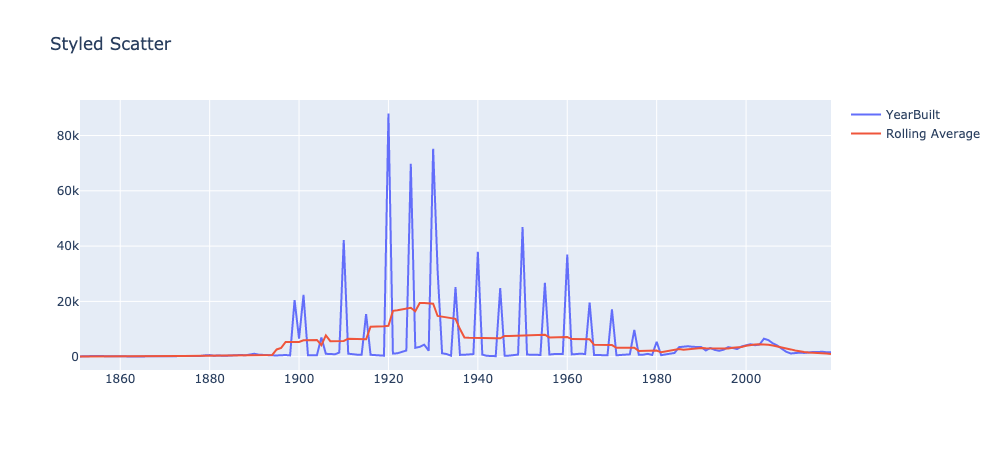

In [15]:
x = ny.groupby('yearbuilt').count()['bbl'].index
y = ny.groupby('yearbuilt').count()['bbl']

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

y_av = movingaverage(y, 10)

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y, name='Recorded Year Built'))
fig.add_trace(go.Scatter(x=x, y=y_av,name='Rolling Average'))

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig.update_layout(title='Styled Scatter',
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()


Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

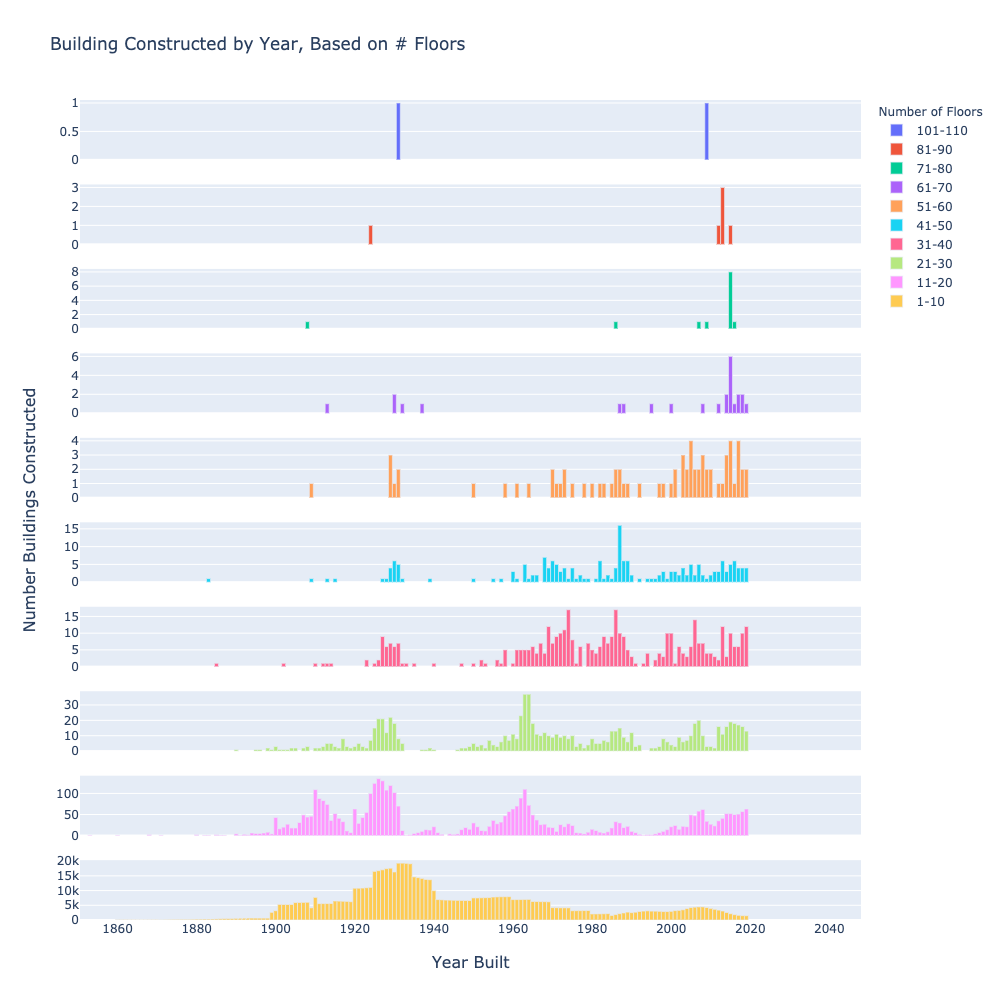

In [66]:
# ny2 = ny.sort_values(by=['yearbuilt']).reset_index()
# ny2['yearbuilt_ma'] = ny2['yearbuilt'].rolling(10).mean()

ny['floors_bucket_10s'] = np.ceil(ny['numfloors'] / 10).astype(int)
floors_bucket = ny.groupby(['floors_bucket_10s', 'yearbuilt'])['bbl'].count().reset_index()

# import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

floors = sorted(floors_bucket['floors_bucket_10s'].unique(), reverse=True)

fig = make_subplots(rows=len(floors), 
                    cols=1, 
                    shared_xaxes=True,
                    x_title='Year Built',
                    y_title='Number Buildings Constructed')

for i, floor in enumerate(floors):
    subset = floors_bucket[floors_bucket['floors_bucket_10s']==floor]
    y = subset['bbl'] if floor > 1 else subset['bbl'].rolling(10).mean()
    
    fig.add_trace(go.Bar(x=subset['yearbuilt'], 
                         y=y, 
                         width=1,
                         name=f'{(floor-1)*10+1}-{(floor*10)}'),
                         row=i+1, col=1)

fig.update_layout(height=1000, width=1000, 
                  legend_title="Number of Floors",
                  title_text="Building Constructed by Year, Based on # Floors",)
fig.show()


Note: Buildings between 1 and 10 floors have unusual *yearbuilt* values for construction up to 1980 and appear to be reported only in 5 year incrememts.  Possibly this was a data error or related to encoding when moving from paper to digital records.  For this chart, these building are reported using a 10-year rolling average for the constrution year to smooth out the extreme bars.  While this is less accurate, for this analysis, we are more concerned with the taller buildings (safty inspection) and those *yearbuilt* vlues seem more reasonable.

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

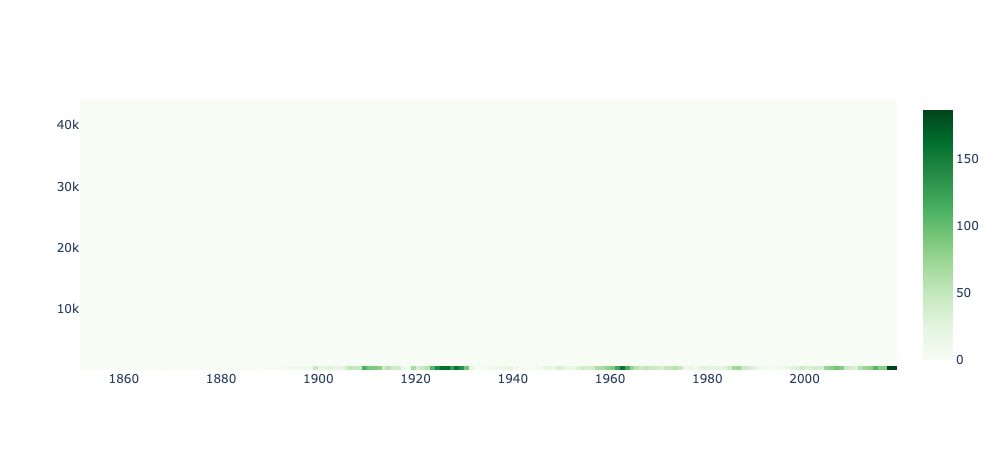

In [78]:
yearbins = int(ny['yearbuilt'].max() - ny['yearbuilt'].min())
floorbins = int(np.log(ny['numfloors'].max()) - 1)

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = z, colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

fig.show()

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



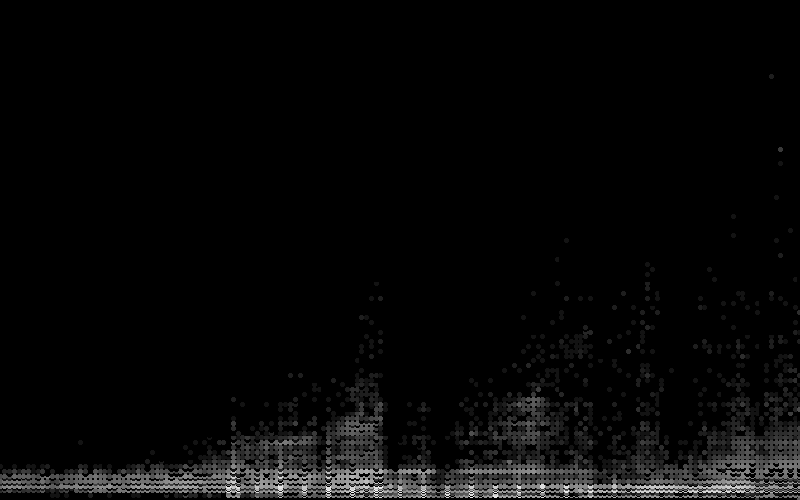

In [80]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

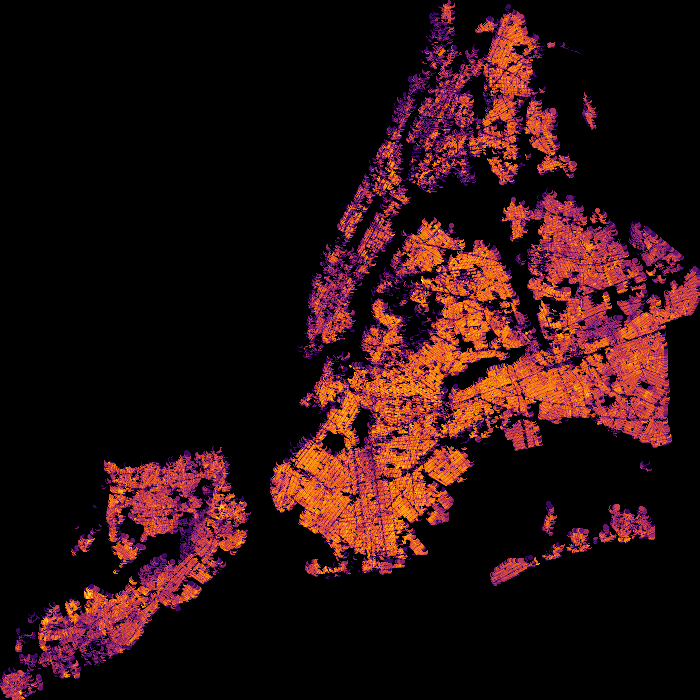

In [81]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

In [93]:
ny['assessstruct'] = ny['assesstot'] - ny['assessland']

cuts1 = ny['assessland'].quantile([0.25,0.5,0.75])
cuts2 = ny['assessstruct'].quantile([0.25,0.5,0.75])

ny['assessland_cat'] = ny['assessland'].map(lambda x: '1' if x < cuts1[0.25] else '2' if x < cuts1[0.75] else '3')
ny['assessstruct_cat'] = ny['assessstruct'].map(lambda x: 'A' if x < cuts2[0.25] else 'B' if x < cuts2[0.75] else 'C')
ny['assess_cat'] = ny['assessstruct_cat'] + ny['assessland_cat']
ny['assess_cat'] = ny['assess_cat'].astype('category')

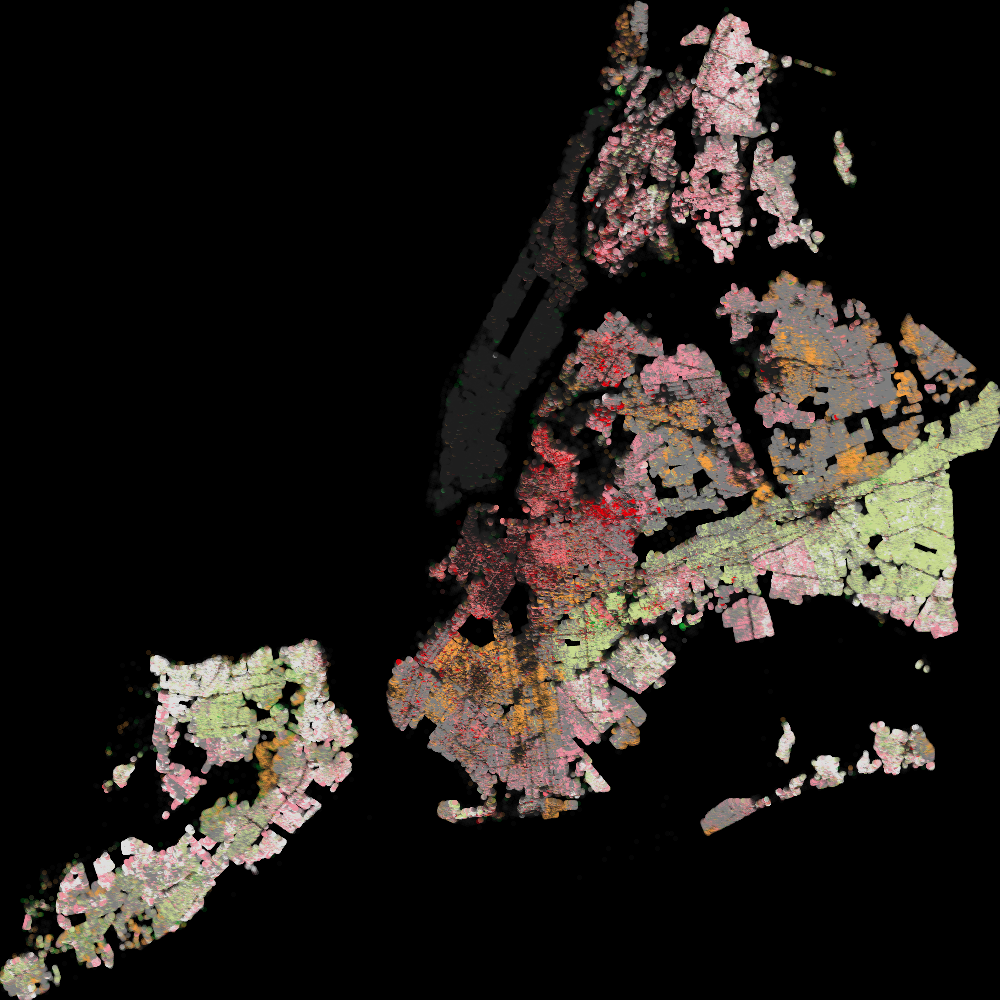

In [114]:
ny['assess_cat'] = ny['assess_cat'].astype('category')

color_key = {'A1': '#151a28', 'A2': '#0b443f', 'A3': '#177e68', 
             'B1': '#411a54', 'B2': '#343e64', 'B3': '#44798e',
             'C1': '#7e4994', 'C2': '#706ca1', 'C3': '#81a7cb'}

color_key = {'A1': '#e0e0e0', 'A2': '#c9db8f', 'A3': '#009926', 
             'B1': '#f090a0', 'B2': '#808080', 'B3': '#faa242',
             'C1': '#f0000b', 'C2': '#f08080', 'C3': '#202020'}

NewYorkCity = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(1000, 1000, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.count_cat('assess_cat'))
view = tf.shade(agg, color_key=color_key, how='eq_hist')
export(tf.spread(view, px=2), 'firery')

Properties are divided into 3 steps for property value and 3 step for structure value using 25% and 75% IQR values to define as cut-offs.  Since we are more interested in extremes, I broke the dimensions into 25%, 50%, 25% as low-, mid- and high-value.  Properties are categorized using a bivariate chloropleth scheme.  Light grey to green represent opportunities with increasing property values, but low-value structures (possibly replaceable).  Structure value goes from light grey to Red indicating low value property, but increasing value structure (less probability for replacement).  Mid grey and Dark grey indicate properties that have both increasing property and structure value and again, as we get darker, there is probably less opportunity for redevelopment.  Orange indicates high property value (this is interesting) and a mid-value structure, which might be a possible location for redevelopment depending on the structure.  Generally we would stay away from reds and dark colors and look to greens and light colors with some orange as a possibility.

**Note: Yes, I used a Red/Green color pallette, which I would never use for public release.  If this was for public consumption, I would have probably leaned towards a yellow/blue/purple scheme.  However, red/green does a better job visually associating color with meaning, i.e. green=go, red=avoid, light=opportunity, dark=less opportunity.**